In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [34]:
#Create X and Y arrays
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Initialize the final arrays correctly
X_final_array = np.empty((0, 3072))  # CIFAR-10 has 3072 features (32x32x3)
Y_final_array = np.empty((0,))  # Correct initialization for Y

for i in range(1, 6):
    # The path to the data
    url = '/Users/josemiguelvilchesfierro/Downloads/cifar-10-batches-py/data_batch_'+str(i)

    # Load the data
    unpickle_data = unpickle(url)
    
    # This is the 'data' which is in uint8 format
    X_temp = unpickle_data[b'data']
    Y_temp = np.array(unpickle_data[b'labels'])  # Convert Y_temp to a NumPy array
    
    # Concatenate temp_array to final_array along axis 0
    X_final_array = np.concatenate((X_final_array, X_temp), axis=0)
    Y_final_array = np.concatenate((Y_final_array, Y_temp), axis=0)

# Convert to tensors
X = torch.tensor(X_final_array)
X = X.view(-1, 3, 32, 32)  # Reshape to (batch_size, channels, height, width)
Y = torch.tensor(Y_final_array)

print(X.shape, Y.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])


In [35]:
#Create tain, dev and test data

#Define the splits
first_split = int(0.8 * len(X))
second_split = int(0.9 * len(X))

# Split the data into training, validation, and test sets
Xtr, Ytr = X[:first_split], Y[:first_split]
Xdev, Ydev = X[first_split:second_split], Y[first_split:second_split]
Xte, Yte = X[second_split:], Y[second_split:]

print (Xtr.shape, Ytr.shape)    
print (Xdev.shape, Ydev.shape)
print (Xte.shape, Yte.shape)

torch.Size([40000, 3, 32, 32]) torch.Size([40000])
torch.Size([5000, 3, 32, 32]) torch.Size([5000])
torch.Size([5000, 3, 32, 32]) torch.Size([5000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.0..254.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [20.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.0..234.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].


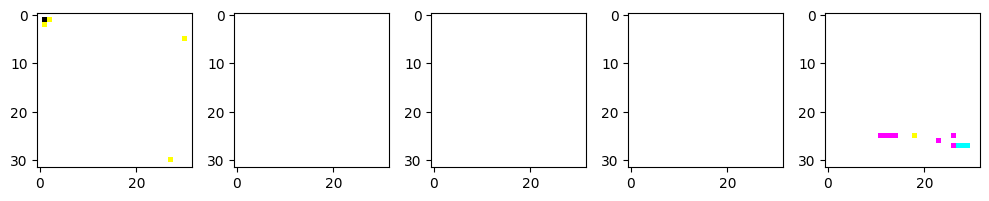

In [36]:
#Showing pictures

# Create a figure with subplots to display multiple images
plt.figure(figsize=(10, 5))  # Adjust the size as needed

# Loop to display 10 images
for i in range(5):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    img = X[i].reshape(3, 32, 32).permute(1, 2, 0)  # Reshape and permute the image tensor
    plt.imshow(img.detach().numpy())  # Convert to NumPy and display

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show all images

In [59]:
import torch
import torch.nn.functional as F

class linear:
    def __init__(self, input_size, output_size):
        self.weights = torch.randn(input_size, output_size, dtype=torch.float32) * 0.3
        self.biases = torch.zeros(output_size, dtype=torch.float32) * 0.3

    def forward(self, input):
        self.input = input.float()
        self.output = torch.mm(self.input, self.weights) + self.biases
        return self.output

    def __call__(self, X):
        return self.forward(X)
    
    def parameters(self):
        return [self.weights] if self.biases is None else [self.weights, self.biases]

#----------------------------------------------------------------------
class convolutional:
    def __init__(self, input_depth, n_kernels, kernel_size):
        self.input_depth = input_depth
        self.kernel_size = kernel_size
        self.n_kernels = n_kernels
        self.kernels = torch.randn(n_kernels, input_depth, kernel_size, kernel_size, dtype=torch.float32) * 0.1 
        self.biases = torch.zeros(n_kernels, dtype=torch.float32) * 0.3

    def forward(self, input):
        self.input = input.float()
        print(f"forward pass input shape = {input.shape}")  
        self.output = F.conv2d(self.input, self.kernels, self.biases)
        print(f"forward pass output shape = {input.shape}")
        return self.output
    
    def __call__(self,X):
        return self.forward(X)
    
    def parameters(self):
        return [self.kernels, self.biases]
#----------------------------------------------------------------------
class sequential:
    def __init__(self, layers):
        self.layers = layers      

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def train(self):
        self.is_training = True  # Set mode to training
        for layer in self.layers:
            if hasattr(layer, 'train'):
                layer.train()

    def eval(self):
        self.is_training = False  # Set mode to evaluation
        for layer in self.layers:
            if hasattr(layer, 'eval'):
                layer.eval()
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        self.out = [p for layer in self.layers for p in layer.parameters()]
        return self.out

#----------------------------------------------------------------------
class ReLU:
    def __call__(self, x):
        return torch.relu(x)
    
    def parameters(self):
        return []
#----------------------------------------------------------------------

class reshape():
    def __init__(self, output_shape):
        self.output_shape = output_shape

    def __call__(self, X):
        return self.forward(X)

    def forward(self, input):
        print(f"Reshape Input shape : {input.shape}")
        batch_size = input.shape[0]
        self.output = input.view(batch_size, -1)  # Flatten the input dynamically
        print(f"Reshape Output shape : {self.output.shape}")
        return self.output
    
    def parameters(self):
        return []
    
#----------------------------------------------------------------------
  
class Dropout:
    def __init__(self, p=0.5):
        self.p = p  # Probability of dropping neurons

    def __call__(self, x):
        return F.dropout(x, self.p, training=True)
    
    def parameters(self):
        return []
    
    def train(self):
        self.is_training = True

    def eval(self):
        self.is_training = False

#----------------------------------------------------------------------

class maxpool:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size

    def __call__(self, x):
        return self.forward(x)

    def forward(self, input):
        self.input = input
        self.output = F.max_pool2d(self.input, self.kernel_size)
        return self.output
    
    def parameters(self):
        return []

In [60]:
# Define your kernel size and number of kernels
kernel_size = 3
n_kernels = 32
input_depth = X.shape[1]

# Build the model
model = sequential([
    convolutional(input_depth, n_kernels, kernel_size), ReLU(),
    convolutional(n_kernels, n_kernels, kernel_size), ReLU(),
    maxpool(2),
    convolutional(n_kernels, kernel_size, n_kernels), ReLU(),
    reshape([n_kernels * 6 * 6]),
    linear(n_kernels * 4 * 4, 10),
])

#Set parameters to train
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

113581


In [61]:
max_epochs = 10
batch_size = 32
lossi = [] 
lrei = []
steps = []

# Set the model to training mode
model.train()

for epoch in range(max_epochs):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb.long())  # Convert target labels to Long data type
    
    # Zero gradients, backpropagate, and update weights
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lre = 0.05 if i < 10000 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= p.grad * lre  # Update weights using learning rate
    
    lossi.append(loss.item())
    lrei.append(lre)
    steps.append(i)

    # Print the loss every 1000 epochs
    if epoch % 10000 == 0:
        print(f'Epoch [{epoch}/{max_epochs}], Loss: {loss.item():.4f}')


forward pass input shape = torch.Size([32, 3, 32, 32])
forward pass output shape = torch.Size([32, 3, 32, 32])
forward pass input shape = torch.Size([32, 32, 30, 30])
forward pass output shape = torch.Size([32, 32, 30, 30])
forward pass input shape = torch.Size([32, 32, 14, 14])


RuntimeError: Calculated padded input size per channel: (14 x 14). Kernel size: (32 x 32). Kernel size can't be greater than actual input size

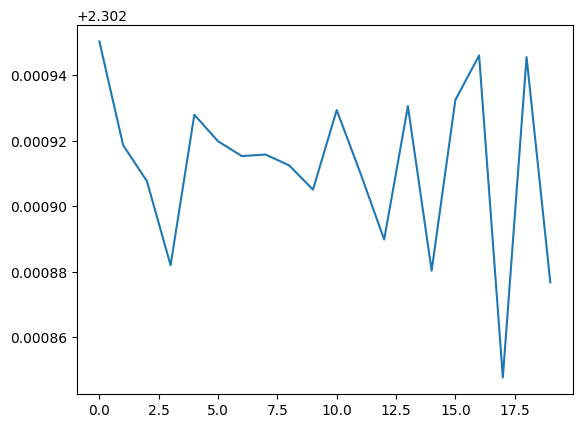

In [51]:
plt.plot(torch.tensor(lossi).view(-1,10000).mean(1));



In [41]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [53]:
#Test the model with dev data
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(value):
    x,y = {'train': (Xtr, Ytr), 'val': (Xdev, Ydev)}[value]
    logits = model(x)
    loss = F.cross_entropy(logits, y.long())
    print(f'{value} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.3026
val loss: 2.3027


#Performance Log

1) First version    : kernel_size = 3, n_kernels = 2, parameters = 13662, max_steps = 20000 --> train loss: 2.2277 | val loss: 2.2389
1) First version (2): kernel_size = 3, n_kernels = 2, parameters = 20542, max_steps = 20000 --> train loss: 2.4063 | val loss: 2.4111

In [52]:
import torch.nn.functional as F

# During evaluation
def evaluate_model(model, X_eval, Y_eval):
    with torch.no_grad():
        # Forward pass
        logits = model(X_eval)

        # Apply softmax to logits to get probabilities
        probabilities = F.softmax(logits, dim=1)
        
        # Get predicted class by taking argmax of the probabilities
        _, predicted_labels = torch.max(probabilities, dim=1)

        correct_predictions = (predicted_labels == Y_eval).sum().item()
        total_samples = Y_eval.shape[0]
        accuracy = correct_predictions / total_samples * 100
        
        print(f"Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_samples} correct)")
    
    return accuracy

evaluate_model(model, Xte, Yte)

Accuracy: 9.76% (488/5000 correct)


9.76